## Neural Network

In [32]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import  classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Loading pre processed datas
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')
weights = np.load('Pre_Processed_Data\class_weights.npy', allow_pickle=True).item()

# Let's convert data to PyTorch tensors

In [33]:
# Convert the class weight dictionary to a PyTorch tensor of type Float
weights_tensor = torch.tensor([weights[i] for i in range(len(weights))]).float()

X_train = torch.tensor(train_features).float()
y_train = torch.tensor(train_labels).long()
X_val = torch.tensor(val_features).float()
y_val = torch.tensor(val_labels).long()
X_test = torch.tensor(test_features).float()
y_test = torch.tensor(test_labels).long()

# Creating DataLoaders for the training and validation set

In [34]:
batch_size = 10
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Defining neural network architecture

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(train_features.shape[1], 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        # Pass data through the new hidden layer
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.fc5(x)
        return x

# Creating an instance of the model

In [36]:
model = Net()

# Let's define the loss function and the optimizer

In [37]:
# I define the loss function and optimizer with class weights
# I create an instance of the CrossEntropyLoss policy using class weights

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Defining the function to validate the model on the validation set

In [38]:
def validate_model(model, validation_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    loss_function = nn.CrossEntropyLoss(weight=weights_tensor)
    
    with torch.no_grad():
        for features, labels in validation_loader:
            outputs = model(features)
            loss= loss_function(outputs,labels) 

    return loss

# I define the variables for early stopping

In [39]:
# Definisci le variabili per l'early stopping
best_accuracy_validation = np.inf  # Valore iniziale per il confronto
patience = 20  # Numero di epoche per tollerare la diminuzione dell'accuratezza sul set di validazione
delta_threshold = 0.0001    # Soglia di miglioramento basata sull'accuratezza sul set di validazione
counter = 0  # Contatore per il numero di epoche senza miglioramento

# Training the model

In [40]:
num_epochs=1000 
for epoch in range(num_epochs):
    model.train() 
    epoch_loss_sum=0.0 
    for i,(features,labels) in enumerate(train_loader):
        optimizer.zero_grad() 
        outputs=model(features) 
        loss=criterion(outputs,labels) 
        epoch_loss_sum+=loss.item() 
        loss.backward() 
        optimizer.step() 
    epoch_loss_avg=epoch_loss_sum/len(train_loader) 
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}')
    
    # Verifico se l'accuratezza corrente sul set di validazione è migliore dell'accuratezza migliore finora
    accuracy_validation=validate_model(model,val_loader) 
    print(accuracy_validation)
    if best_accuracy_validation - accuracy_validation>delta_threshold: 
        best_accuracy_validation = accuracy_validation 
        counter=0 
        torch.save(model.state_dict(),'best_model.pth') 
    else: 
        counter+=1 

    # Stampo l'accuratezza sul set di validazione ogni 10 epoche
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Accuracy on validation set: {accuracy_validation:.4f}')

    if counter>=patience: 
        print(f'Stopping early at epoch {epoch + 1}')
        break

Epoch [1/1000], Loss: 0.6936
tensor(0.6933)
Epoch [2/1000], Loss: 0.6930
tensor(0.6914)
Epoch [3/1000], Loss: 0.6908
tensor(0.6788)
Epoch [4/1000], Loss: 0.6854
tensor(0.6956)
Epoch [5/1000], Loss: 0.6861
tensor(0.6776)
Epoch [6/1000], Loss: 0.6664
tensor(0.6341)
Epoch [7/1000], Loss: 0.6344
tensor(0.6232)
Epoch [8/1000], Loss: 0.6167
tensor(0.5604)
Epoch [9/1000], Loss: 0.6374
tensor(0.5444)
Epoch [10/1000], Loss: 0.5970
tensor(0.5880)
Epoch [10/1000], Accuracy on validation set: 0.5880
Epoch [11/1000], Loss: 0.5996
tensor(0.5279)
Epoch [12/1000], Loss: 0.6087
tensor(0.5375)
Epoch [13/1000], Loss: 0.5643
tensor(0.5338)
Epoch [14/1000], Loss: 0.6036
tensor(0.5126)
Epoch [15/1000], Loss: 0.5828
tensor(0.5699)
Epoch [16/1000], Loss: 0.5541
tensor(0.4892)
Epoch [17/1000], Loss: 0.5890
tensor(0.4923)
Epoch [18/1000], Loss: 0.5322
tensor(0.4815)
Epoch [19/1000], Loss: 0.5543
tensor(0.5918)
Epoch [20/1000], Loss: 0.5442
tensor(0.4895)
Epoch [20/1000], Accuracy on validation set: 0.4895
Epoch

# Carica il miglior modello

In [41]:
# Loading the best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

# Evaluating the model on test set

In [42]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _tmp, test_predictions = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (test_predictions == labels).sum().item() 

# accuracy
accuracy = correct/total
print(f'Accuracy on test set: {accuracy:.4f}')

Accuracy on test set: 0.6797


# Confusion Matrix

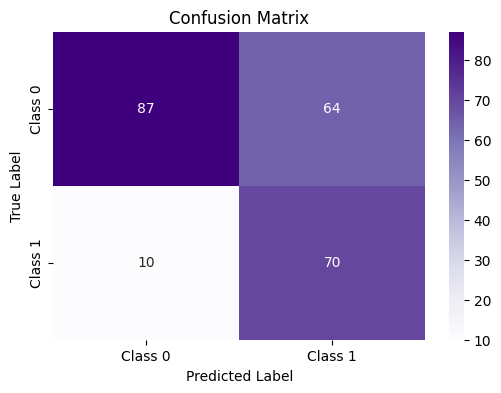

In [43]:
# Compute confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _tmp, test_predictions = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(test_predictions.tolist())

cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report

In [44]:
model.eval()
test_predictions = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        _tmp, batch_predictions = torch.max(outputs.data, 1)
        test_predictions.extend(batch_predictions.tolist())

# Calcolo il report di classificazione
report = classification_report(test_labels.tolist(), test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.58      0.70       151
           1       0.52      0.88      0.65        80

    accuracy                           0.68       231
   macro avg       0.71      0.73      0.68       231
weighted avg       0.77      0.68      0.69       231



# ROC and AUC

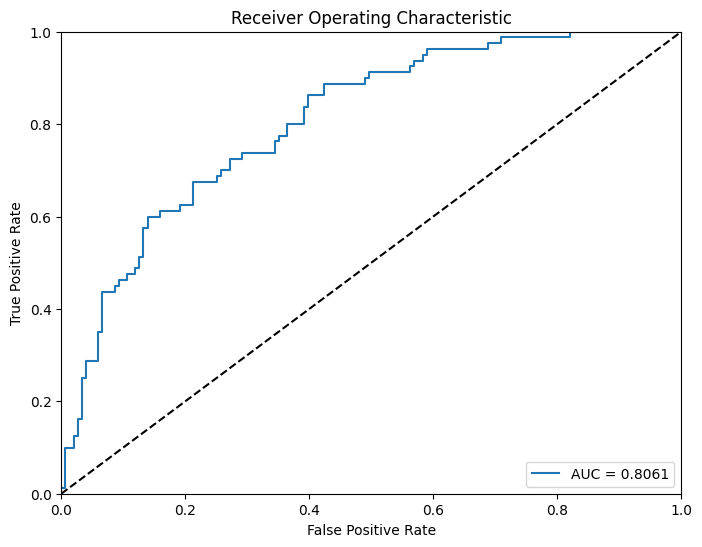

AUC: 0.8061258278145695


In [45]:
model.eval()
test_probabilities = []

with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        probabilities = torch.softmax(outputs, dim=1)
        test_probabilities.extend(probabilities[:, 1].tolist())

# Calcolo la curva ROC e l'AUC
fpr, tpr, thresholds = roc_curve(test_labels.tolist(), test_probabilities)
auc = roc_auc_score(test_labels.tolist(), test_probabilities)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("AUC:", auc)

# Cross Validation

In [46]:
from sklearn.model_selection import KFold

def cross_validate(model, criterion, optimizer, X, y, k=5):
    kfold = KFold(n_splits=k)
    accuracy_scores = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        train_data = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_data = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_data, batch_size=batch_size)

        best_accuracy_validation = 0
        counter = 0

        for epoch in range(num_epochs):
            model.train()
            epoch_loss_sum = 0.0
            for i, (features, labels) in enumerate(train_loader):
                optimizer.zero_grad()
                outputs = model(features)
                loss = criterion(outputs, labels)
                epoch_loss_sum += loss.item()
                loss.backward()
                optimizer.step()

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in val_loader:
                    outputs = model(features)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy_validation = correct / total
            if accuracy_validation > best_accuracy_validation:
                best_accuracy_validation = accuracy_validation
                counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                counter += 1

            if counter >= patience:
                break

        model.load_state_dict(torch.load('best_model.pth'))
        accuracy_scores.append(accuracy_validation)

    return np.mean(accuracy_scores)


model = Net()

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

accuracy = cross_validate(model, criterion, optimizer, X_train, y_train)
print(f'Accuracy with cross validation: {accuracy:.4f}')

Accuracy with cross validation: 0.7066
